## Get the rough shape

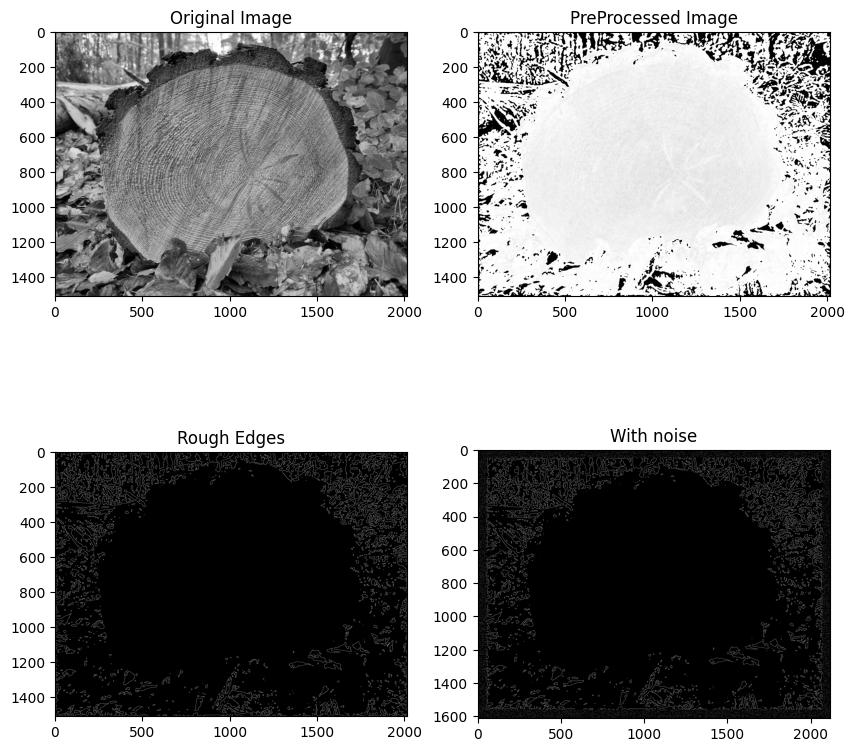

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np
import skimage.filters as filt
import imutils
from PIL import Image
from skimage.morphology import reconstruction
import scipy.ndimage as nd
import cv2 as cv

# load image
img = pltimg.imread("./input.tif")
# load original image
fig,ax =plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(img,cmap=plt.get_cmap('gray'))
ax[0][0].title.set_text("Original Image")
# show image
image = cv.Laplacian(img,cv.CV_32F)
seed = np.copy(image)
seed[3:-3, 3:-3] = image.min()
mask = image
dilated = reconstruction(seed, mask, method='dilation')
# make gaussian to blur the inside of the image
gaussianOfDilated = np.uint8(filt.gaussian(dilated,sigma=(3,3),truncate=3,channel_axis=2))
ax[0][1].imshow(gaussianOfDilated,cmap=plt.get_cmap('gray'))
ax[0][1].title.set_text("PreProcessed Image")
# detect edges to see the rough shape of the tree trunc
edges = cv.Canny(gaussianOfDilated, 100, 200)
ax[1][0].imshow(edges,cmap=plt.get_cmap('gray'))
ax[1][0].title.set_text("Rough Edges")

image = np.zeros(shape=(img.shape[0]+100,img.shape[1]+100),dtype=np.uint8)
# make black and white noise image
x = np.random.randint(0, image.shape[1] - 1, int(0.05 * image.size))
y = np.random.randint(0, image.shape[0] - 1, int(0.05 * image.size))
image[y, x] = 255

image[50:-50,50:-50] = edges
ax[1][1].imshow(image,cmap=plt.get_cmap('gray'))
ax[1][1].title.set_text("With noise")

plt.show()

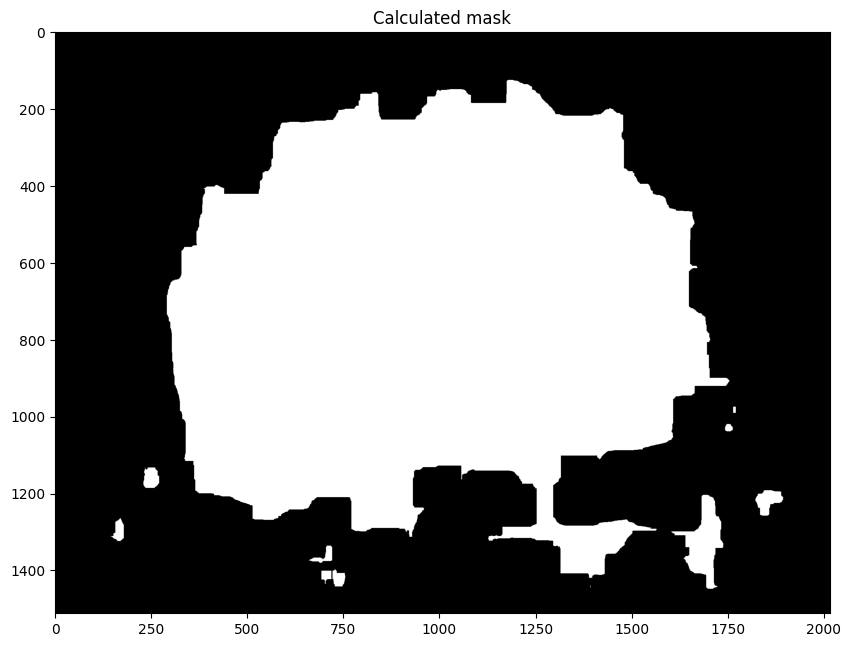

In [2]:
targetImage = np.zeros(img.shape,dtype=np.uint8)
def fill_roughly(x,y):
    subimage= image[x:x+100,y:y+100]
    left = subimage[0:50]
    right =subimage[50:100]
    top  = subimage[0:100,0:50]
    bottom = subimage[0:100,50:100]
    countleft = np.count_nonzero(left == 255)
    countright = np.count_nonzero(right == 255)
    counttop = np.count_nonzero(top == 255)
    countbottom = np.count_nonzero(bottom == 255)
    relHor = abs((countleft-countright)/50)
    relVer = abs((counttop-countbottom)/50)
    if (relHor<0.7 or relVer<0.7) and countbottom+counttop<30:
        return True
    else:
        return False
for x in range(edges.shape[0]):
    for y in range(edges.shape[1]):
        if fill_roughly(x,y):
            targetImage[x,y] = 255

fig,ax =plt.subplots(1,1,figsize=(10,10))
ax.imshow(targetImage,cmap=plt.get_cmap('gray'))
ax.title.set_text("Calculated mask")
plt.show()

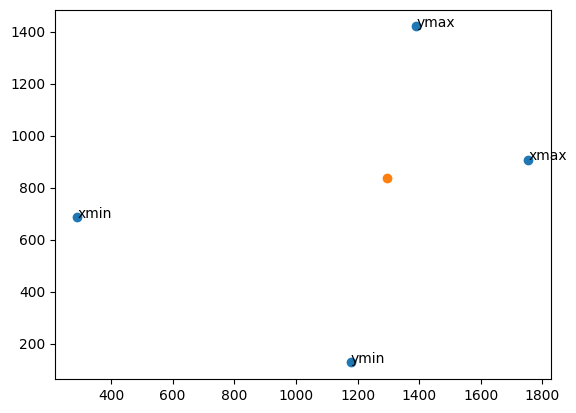

In [37]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

contours = cv.findContours(targetImage.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(contours)
c = max(cnts, key=cv.contourArea)
# get all points
xs = c[:, 0, 0]
ys = c[:, 0, 1]
# get the maximas of each to draw lines and get the middle point
ymax = np.amax(ys)
index = np.where(ys == ymax)
ymax = np.array([xs[index][0], ymax])

ymin = np.amin(ys)
index = np.where(ys == ymin)
ymin = np.array([xs[index][0], ymin])

xmax = np.amax(xs)
index = np.where(xs == xmax)
xmax = np.array([xmax, ys[index][0]])

xmin = np.amin(xs)
index = np.where(xs == xmin)
xmin = np.array([xmin, ys[index][0]])

# calculate intersection
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1
# show intersects
xIntersec,yIntersec = seg_intersect(xmin,xmax,ymin,ymax)
points = np.array([xmin,xmax,ymin,ymax])
n = ["xmin","xmax","ymin","ymax"]
plt.scatter(points[:,0],points[:,1])
for i, txt in enumerate(n):
        plt.annotate(txt, (points[i][0], points[i][1]))
plt.scatter(xIntersec,yIntersec)
plt.show()

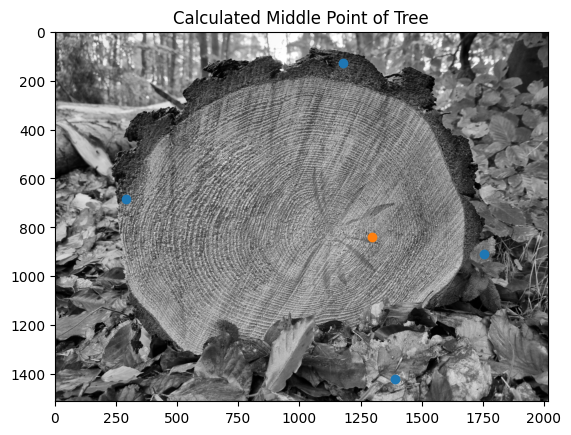

<Figure size 640x480 with 0 Axes>

In [47]:
plt.gray()
plt.imshow(img)
plt.scatter(points[:,0],points[:,1])
plt.scatter(xIntersec,yIntersec)
plt.title("Calculated Middle Point of Tree")
plt.show()
plt.savefig("./test.tiff")